<a href="https://colab.research.google.com/github/hyunyongPark/Recommendation/blob/master/DeepAutoEncoderContent_Simple_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preparation

In [ ]:
# Raw Data
df = pd.read_csv('/content/gdrive/My Drive/recommend_practice/recsys_autoencoders-master/data/raw/rating.csv', header = None)
df.columns = ['user_id', 'game', 'type', 'hours', 'none']
df

,user_id,game,type,hours,none
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
...,...,...,...,...,...
199995,128470551,Titan Souls,play,1.5,0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0,0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0
199998,128470551,RUSH,purchase,1.0,0


In [ ]:
# Train Data (subset of all interactions)
df = pd.read_csv('/content/gdrive/My Drive/recommend_practice/recsys_autoencoders-master/data/interactions_train_df.csv')
df = df[['user_id', 'content_id', 'game', 'view']]
df

,user_id,content_id,game,view
0,134,1680,Far Cry 3 Blood Dragon,1
1,2219,1938,Gone Home,1
2,3315,3711,Serious Sam 3 BFE,1
3,3440,4784,Velvet Sundown,1
4,870,4104,Super Hexagon,1
...,...,...,...,...
92106,1215,364,Assetto Corsa,1
92107,1122,2690,Metro 2033,1
92108,605,2984,"On the Rain-Slick Precipice of Darkness, Episo...",1
92109,3096,2935,Nosgoth,1


In [ ]:
len(df.content_id.unique())

4862

In [ ]:
# Content Data of Games
df_game = pd.read_csv('/content/gdrive/My Drive/recommend_practice/recsys_autoencoders-master/data/articles_df.csv')
df_game.head(4)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9


### Create a Matrix of Interactions

In [ ]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = df.pivot(index   = 'user_id', 
                                 columns = 'content_id', 
                                 values  = 'view').fillna(0)
users_items_matrix_df

content_id,0,1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,42,43,44,...,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_matrix_df.shape

(3757, 4862)

In [ ]:
users_items_matrix_df.values.mean()*100   # 평점 평균

0.5042609616033342

### Create a Input Content

In [ ]:
def split_str(val):
    '''
    Sprint String list
    '''
    tokens = []
    for v in val:
        tokens.extend(v.split(' '))
    return " ".join(tokens)

In [ ]:
# Group games per user
user_games = df.groupby('user_id')['game'].apply(list).reset_index()
user_games.head(2)

,user_id,game
0,0,"[Day of Defeat, Half-Life, Counter-Strike Sour..."
1,1,"[Ricochet, The Stanley Parable, Thief Gold, To..."


In [ ]:
# Split games names
user_games['tokens'] = user_games['game'].apply(split_str)
user_games.head(2)

,user_id,game,tokens
0,0,"[Day of Defeat, Half-Life, Counter-Strike Sour...",Day of Defeat Half-Life Counter-Strike Source ...
1,1,"[Ricochet, The Stanley Parable, Thief Gold, To...",Ricochet The Stanley Parable Thief Gold Total ...


In [ ]:
df.loc[df['game'] == 'Day of Defeat', 'game']   # 게임 이름을 토큰화하는지 확인

190      Day of Defeat
276      Day of Defeat
638      Day of Defeat
710      Day of Defeat
826      Day of Defeat
             ...      
91922    Day of Defeat
91975    Day of Defeat
92002    Day of Defeat
92022    Day of Defeat
92103    Day of Defeat
Name: game, Length: 420, dtype: object

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# integer encode the documents   문서를 정수 인코딩
vocab_size   = 100
encoded_docs = [one_hot(d, vocab_size) for d in user_games.tokens]
print(encoded_docs)
print(len(encoded_docs))

[[66, 51, 96, 85, 32, 99, 4, 33, 85, 32, 9, 1, 90, 79, 49, 60, 31, 7, 2, 81, 60, 23, 99, 4, 13, 85, 32, 9, 39, 3, 85, 32, 9, 68, 25, 12, 9, 1, 7, 85, 32, 9, 68, 94, 12, 14, 90, 9], [13, 37, 59, 21, 2, 2, 85, 41, 88, 2, 9, 2, 72, 58, 99, 4, 85, 32, 32, 51, 73, 80, 99, 41, 10, 67, 99, 4, 85, 43, 21, 9, 50, 71, 59, 67, 9, 51, 26, 89, 56, 21, 9, 50, 71, 2, 75, 21, 9, 2, 7, 2, 32, 51, 73, 46, 87, 30, 15, 66, 51, 96, 32, 51, 73, 46, 87, 9, 15, 60, 31, 7, 79, 49, 32, 51, 73, 46, 87, 30, 99, 4, 33, 2, 32, 42, 51, 22, 83, 45, 56, 2, 37, 95, 19, 32, 51, 73, 46, 87, 9], [2, 81, 46, 51, 37, 23, 56, 42, 51, 22, 83, 45, 37, 83, 95, 81, 7, 23, 86, 74, 85, 32, 9, 68, 25, 2, 81, 60, 23, 37, 5, 13, 28, 60, 9, 28, 60, 42, 51, 22, 83, 45, 56, 66, 51, 96, 37, 13, 14, 30, 3, 13, 79, 49, 38, 30, 45, 50, 40, 85, 99, 95, 81, 7, 23, 40, 33, 9, 37, 98, 13, 1, 7, 3, 9, 79, 49, 38, 74, 37, 32, 18, 3, 81, 90, 52, 3, 93, 85, 32, 9, 3, 81, 96, 76, 82, 83, 85, 78, 37, 53, 76, 47, 3, 37, 86, 38, 43, 24, 45, 21, 32, 15,

In [ ]:
a = []
for i in range(len(encoded_docs)):
  a.append(len(encoded_docs[i]))

max(a)

2954

In [ ]:
# pad documents to a max length of 4 words   최대 4단어 길이로 문서 채우기
max_length  = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
print(len(padded_docs), '\t' ,len(padded_docs[0]))

[[86 69 49 ... 33  0  0]
 [75 12 69 ... 70 93 33]
 [68 76 28 ... 55 50 86]
 ...
 [74  2 20 ...  0  0  0]
 [60 62 54 ...  0  0  0]
 [ 9 47 84 ...  0  0  0]]
3757 	 50


## Model

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Embedding, Flatten, add
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''
    users_items_matrix, content_info = X

    # Input
    input_layer   = Input(shape=(users_items_matrix.shape[1],), name='UserScore')
    input_content = Input(shape=(content_info.shape[1],), name='Itemcontent')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Content Information
    x_content = Embedding(100, 256, input_length=content_info.shape[1])(input_content)
    x_content = Flatten()(x_content)
    x_content = Dense(256, activation='selu', 
                                name='ItemLatentSpace')(x_content)
    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='UserLatentSpace')(enc)
    
    lat_space= add([lat_space, x_content], name='LatentSpace')
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(users_items_matrix.shape[1], activation='linear', name='UserScorePred')(dec)  # 바닐라 오토인코더에서는 아웃풋을 선형활성화함수를 쓰는게 일반적이라고 함.

    # this model maps an input to its reconstruction
    model = Model([input_layer, input_content], output_layer)    
    
    return model

In [ ]:
# input
X = [users_items_matrix_df.values, padded_docs]
y = users_items_matrix_df.values

In [ ]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Itemcontent (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
UserScore (InputLayer)          [(None, 4862)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      25600       Itemcontent[0][0]                
__________________________________________________________________________________________________
EncLayer1 (Dense)               (None, 512)          2489856     UserScore[0][0]                  
_______________________________________________________________________________________

### Train Model

In [ ]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

Epoch 1/50
53/53 [==============================] - 6s 115ms/step - loss: 0.0294 - val_loss: 0.0040
Epoch 2/50
53/53 [==============================] - 6s 114ms/step - loss: 0.0192 - val_loss: 0.0033
Epoch 3/50
53/53 [==============================] - 6s 115ms/step - loss: 0.0142 - val_loss: 0.0029
Epoch 4/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0114 - val_loss: 0.0026
Epoch 5/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0095 - val_loss: 0.0024
Epoch 6/50
53/53 [==============================] - 6s 114ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 7/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0075 - val_loss: 0.0022
Epoch 8/50
53/53 [==============================] - 6s 114ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 9/50
53/53 [==============================] - 6s 114ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 10/50
53/53 [==============================] - 6s 114ms/step - loss: 0.0061 - val_loss: 0.0020

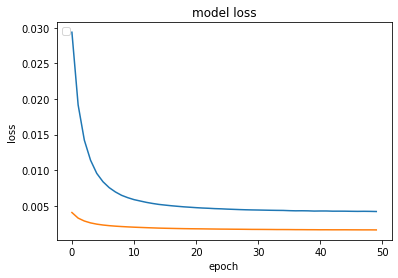

In [ ]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [ ]:
# Predict new Matrix Interactions, set score zero on visualized games
new_matrix = model.predict(X) * (X[0] == 0)

In [ ]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

content_id,0,1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,42,43,44,...,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.001920,-0.004056,0.000950,0.005175,0.003394,-0.008379,-0.007216,-0.014436,-0.011238,-0.000561,-0.005458,0.006076,-0.013004,-0.000607,0.001118,0.008733,0.000341,0.001710,-0.005381,0.001364,-0.000892,-0.004026,0.004046,-0.005532,0.009827,0.010583,0.006180,0.008280,0.010251,0.007760,-0.005819,-0.004041,0.004059,0.002528,-0.007994,0.005722,-0.001433,0.000522,-0.003739,-0.002193,...,-0.004899,-0.000915,-0.004958,0.003445,-0.003246,0.012364,0.003329,-0.003329,-0.002006,-0.002606,-0.005662,0.007837,-0.007080,-0.004857,0.002358,-0.009154,0.004495,0.003266,0.004895,0.000396,-0.007718,0.006935,0.000891,0.001807,-0.010142,0.002547,0.003660,0.009993,-0.003566,0.000306,0.004359,0.005393,-0.000010,-0.012524,0.000670,-0.009463,0.006128,-0.005514,-0.024403,0.000199
1,-0.001553,-0.005616,-0.001020,0.002967,0.002605,0.004062,0.005985,-0.001091,0.004207,0.002899,-0.007441,-0.009031,-0.002801,0.000393,-0.002618,-0.004454,-0.001541,-0.002122,-0.004480,0.015342,-0.001574,-0.003181,0.001645,0.002147,0.011477,-0.002766,0.011987,0.004289,-0.003594,0.006363,0.004503,0.022666,0.000017,0.004524,0.030839,0.004161,0.001579,0.009612,0.005898,0.014594,...,-0.001275,0.009462,0.002066,0.001137,-0.008831,0.001279,0.002609,-0.001987,0.000861,-0.002475,0.018253,0.012916,0.007906,0.009335,-0.005189,-0.002649,0.002863,-0.003227,0.006435,-0.007364,-0.002606,0.003443,-0.000769,-0.002179,-0.002368,0.001427,0.005389,-0.001685,-0.003642,0.001511,0.009937,0.003683,-0.001376,0.022524,-0.008090,-0.011094,-0.004603,0.004506,0.008276,0.006796
2,0.001062,0.003488,-0.003923,0.010736,-0.005869,0.027633,-0.004980,-0.008343,-0.009168,0.000921,-0.003142,-0.006370,-0.001384,0.014229,-0.007808,-0.005537,0.004565,-0.008327,-0.006297,0.002684,-0.005414,0.000306,0.018922,-0.005959,0.016262,0.023211,0.016417,0.022127,0.021263,0.010303,-0.006515,0.017929,-0.011194,0.000126,0.005288,-0.002284,-0.014946,0.007919,-0.007195,-0.011604,...,-0.007130,0.006612,-0.008737,0.009008,-0.001578,-0.007340,-0.011506,0.000496,0.006997,-0.008009,0.018798,0.017435,0.018692,0.009053,0.009612,0.012104,0.000583,-0.007336,-0.005224,0.030751,0.001622,-0.002593,0.010835,0.000328,0.007823,0.015678,-0.010430,-0.010167,0.011723,0.005406,0.020256,0.018073,0.004802,0.028684,-0.011958,0.012146,0.007648,-0.013054,-0.050529,0.006929
3,0.004809,-0.000658,-0.002932,0.007357,0.003198,0.004134,-0.003525,-0.005165,-0.002024,-0.001723,0.004264,0.001967,0.001501,-0.003881,0.008741,0.002918,0.002077,0.002950,-0.004871,0.003075,0.003457,-0.004689,-0.000185,-0.002241,0.011678,-0.001805,0.004182,0.004442,-0.010941,-0.008640,0.003821,0.004990,-0.001923,0.007374,-0.005827,0.000279,0.003611,0.005864,0.004490,0.010949,...,-0.006624,0.006543,-0.002778,-0.002942,-0.003622,0.001208,-0.005689,0.000390,-0.000969,0.001521,-0.000742,0.001485,0.001489,-0.003948,0.001694,0.002304,-0.007912,-0.002658,-0.001325,-0.001100,0.003630,0.000641,0.009612,-0.000747,0.000361,0.005089,0.005459,0.002740,-0.003374,0.003064,-0.002750,0.005893,-0.005573,0.008220,-0.002178,-0.006337,-0.005093,0.001627,0.003217,-0.000145
4,-0.002627,0.001101,0.000314,0.004200,0.000707,0.003386,-0.001775,-0.008490,-0.006416,-0.005788,-0.001401,0.000233,0.000176,-0.004102,0.003819,0.002083,0.003166,0.002491,-0.007896,0.007925,-0.002399,-0.006496,-0.000396,-0.003803,0.011988,0.000631,0.008247,0.007930,-0.003978,-0.001926,0.004513,0.006816,-0.005111,0.001325,-0.006364,0.001841,-0.001814,0.004287,-0.000724,0.009279,...,-0.003107,0.003267,0.001482,-0.001607,-0.003547,-0.001611,-0.002068,-0.002752,-0.002918,-0.002578,-0.000956,-0.002636,0.002188,-0.000958,0.001895,-0.000211

In [ ]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-0.47727323 1.467711


In [ ]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Games for UserWarning
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('content_id')\
                    .join(df_content.set_index('content_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'game']]
    
    return df_rec[df_rec.score > 0]

Recommender for **user_id = 1011**. This user prefers games in the same half-life line

In [ ]:
# Games previously purchased by the user
recommender_for_user(user_id         = 1011, 
                     interact_matrix = users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2057,1.0,Half-Life 2 Episode One
2059,1.0,Half-Life 2 Lost Coast


In [ ]:
# Recommended User Games
recommender_for_user(user_id         = 1011, 
                     interact_matrix = new_users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
2058,0.244701,Half-Life 2 Episode Two
2056,0.239319,Half-Life 2 Deathmatch
978,0.148294,Counter-Strike Source
2062,0.147685,Half-Life Deathmatch Source
3197,0.106656,Portal 2
2457,0.098907,Left 4 Dead 2
2064,0.090205,Half-Life Source
1879,0.088477,Garry's Mod
1126,0.071932,Day of Defeat Source


Recommender for **user_id = 1319**. This user prefers games in the same line as the RPG or strategy

In [ ]:
# Games previously purchased by the user
recommender_for_user(user_id         = 1319, 
                     interact_matrix = users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
173,1.0,Age of Empires II HD Edition
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4626,1.0,Total War ATTILA
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
4631,1.0,Total War SHOGUN 2
4328,1.0,The Elder Scrolls V Skyrim


In [ ]:
# Recommended User Games
recommender_for_user(user_id         = 1319, 
                     interact_matrix = new_users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
4330,0.371048,The Elder Scrolls V Skyrim - Dragonborn
3792,0.194265,Sid Meier's Civilization V
3837,0.161924,Skyrim High Resolution Texture Pack
1490,0.125548,Empire Total War
3793,0.122822,Sid Meier's Civilization V Brave New World
4630,0.118772,Total War ROME II - Emperor Edition
4485,0.106437,The Witcher 2 Assassins of Kings Enhanced Edition
175,0.086329,Age of Empires III Complete Collection
2872,0.083978,Napoleon Total War


## DataViz Latent-Space

In [ ]:
model.layers

In [ ]:
from keras.models import Model

def get_encoder(model):
    '''
    Return Encoder Model from AutoEncoder Model
    '''
    layer_name = 'LatentSpace'
    encoder    = Model(inputs=model.input,
                       outputs=model.get_layer(layer_name).output)
    return encoder

# Encoder Model
encoder      = get_encoder(model)

# Predict - Transform Input in LantentSpace
latent_space = encoder.predict(X)

In [ ]:
print(latent_space.shape)
print(latent_space[0])

(3757, 256)
[-0.01199555 -0.16937256  0.05482477  0.03758682 -0.09559328 -0.04377762
  0.10951574 -0.02734676  0.09487452 -0.10237275  0.05856565  0.03912421
 -0.07811642  0.11648493 -0.04315601  0.07602002 -0.003258   -0.10697877
 -0.03094415  0.04194554  0.14026724  0.06415313  0.06106623  0.1313359
  0.05340589  0.03254199 -0.21221873  0.17641324  0.11043742 -0.15912893
  0.12853003 -0.00414526 -0.06792922 -0.09611367 -0.01646055 -0.02198361
  0.05929984 -0.09499548 -0.16264184  0.04224488 -0.03505453  0.06028041
  0.06269745  0.01405727  0.13802215 -0.17116019 -0.0542856  -0.00252745
 -0.0473156   0.1352703  -0.15175669  0.07886825 -0.06899823  0.04957157
  0.01850655 -0.01828656 -0.03207624  0.01020506 -0.04834531  0.03273811
  0.15966488 -0.10013492 -0.23158754 -0.05281922 -0.18716857  0.06602075
  0.15559283  0.08857248  0.02458304 -0.1506174  -0.13517827 -0.0412204
 -0.00922687 -0.07514536  0.08474011 -0.00133876  0.00723419 -0.05772112
  0.00410572 -0.06540951 -0.02931181  0.0

In [ ]:
def plt_reduce(x, color = None):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], c=color,
            alpha=.4, s=3**2, cmap='tab20c')
    plt.grid(False)
    #plt.colorbar()
    plt.show()

In [ ]:
from sklearn.manifold import TSNE

# Reduce dimmension
tsne      = TSNE(n_components=2)
x_reduce  = tsne.fit_transform(latent_space)

In [ ]:
user_games.head()

,user_id,game,tokens
0,0,"[Day of Defeat, Half-Life, Counter-Strike Sour...",Day of Defeat Half-Life Counter-Strike Source ...
1,1,"[Ricochet, The Stanley Parable, Thief Gold, To...",Ricochet The Stanley Parable Thief Gold Total ...
2,2,"[Deus Ex Game of the Year Edition, Age of Empi...",Deus Ex Game of the Year Edition Age of Empire...
3,3,"[Half-Life Opposing Force, Team Fortress Class...",Half-Life Opposing Force Team Fortress Classic...
4,4,"[Half-Life, Day of Defeat, Half-Life Opposing ...",Half-Life Day of Defeat Half-Life Opposing For...


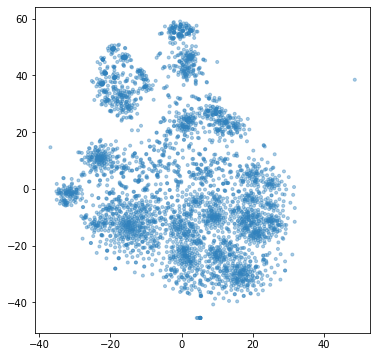

In [ ]:
colors = user_games.tokens.str.contains("")
plt_reduce(x_reduce, colors)

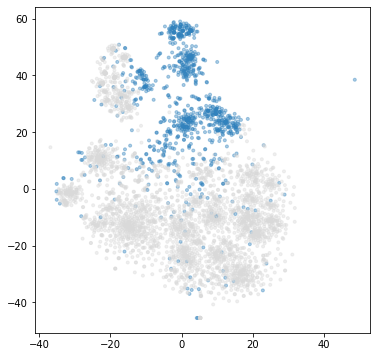

In [ ]:
colors = ~user_games.tokens.str\
            .contains("Half-Life")
plt_reduce(x_reduce, colors)

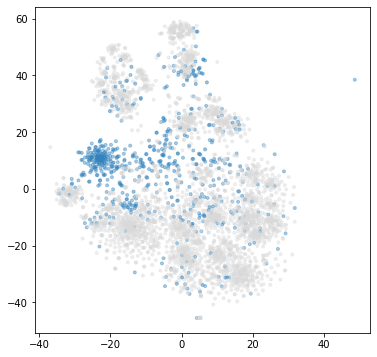

In [ ]:
colors = ~user_games.tokens.str\
            .contains("Elder Scrolls")
plt_reduce(x_reduce, colors)